# Music vs. Speech classification using Neural Nets


The classification has been performed using GTZAN dataset and a feature matrix from:

https://github.com/jyotinarang2/Speech_Music_Classification/blob/master/gtzan_features.csv

This code is based on the Neural Net lab from the NYU Tandon Machine Learning course:
https://github.com/sdrangan/introml/blob/master/neural/lab07_music_partial.ipynb


Load keras and the other packages:

In [282]:
import keras
from __future__ import division # for Python 2.x

In [283]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing the data
Load and display the data:

In [284]:
names = ['RMS','Spectral Slope','Zero Crossings','MFCC(2)','Spectral RollOff','MFCC(4)','MFCC(13)','MFCC(11)','MFCC(1)','MFCC(12)','Spectral Spread','Class']
df = pd.read_csv('https://raw.githubusercontent.com/jyotinarang2/Speech_Music_Classification/master/gtzan_features.csv',
                names=names,na_values='?',header=0)

df = df.dropna()
df.head(6)

,RMS,Spectral Slope,Zero Crossings,MFCC(2),Spectral RollOff,MFCC(4),MFCC(13),MFCC(11),MFCC(1),MFCC(12),Spectral Spread,Class
0,-20.187,-9.740000e-07,0.075458,2.2779,493,1.24320,0.095795,-0.128390,-25.954,-0.017165,616.68,'music'
1,-16.315,-2.270000e-06,0.098657,2.9004,462,0.36602,-0.339310,-0.050032,-22.565,-0.726760,878.82,'speech'
2,-21.369,-5.690000e-07,0.044689,2.3677,1184,0.75089,0.198910,0.214620,-27.885,0.434850,597.75,'music'
3,-17.724,-1.230000e-06,0.116730,1.8504,1170,0.72793,0.125660,0.197170,-23.188,0.333370,1250.10,'music'
4,-29.913,-4.980000e-07,0.094017,2.3898,561,1.44410,0.631700,-0.117360,-26.718,-0.440910,1015.50,'speech'
5,-14.613,-1.400000e-06,0.136750,1.4418,957,0.81468,0.315170,-0.548860,-23.978,0.122330,1283.50,'music'


Number of samples and features:

In [285]:
samples, features = df.shape
print("There are {0} samples with {1} features in the dataset.".format(samples, features-1))

There are 41344 samples with 11 features in the dataset.


Use 30000 samples for training and 11344 samples for testing

In [286]:
xnames =['RMS','Spectral Slope','Zero Crossings','MFCC(2)','Spectral RollOff',
         'MFCC(4)','MFCC(13)','MFCC(11)','MFCC(1)','MFCC(12)','Spectral Spread'] 

Xtr = np.array(df[xnames][:30000])
Xts = np.array(df[xnames][30000:])
ytr = np.array(df['Class'].values[:30000])
yts = np.array(df['Class'][30000:])

a,ytr = np.unique(ytr, return_inverse=True)
a,yts = np.unique(yts, return_inverse=True)


Scale the training set by subtracting its mean and dividing by standard deviation.
Scale the testing set subtracting the mean and dividing by the standard deviation of the training set.

In [287]:
# Scale the training and test matrices
mean = np.mean(Xtr, axis = 0)

std = np.std(Xtr, axis = 0)

Xtr_scale = (Xtr - mean) / std

Xts_scale = (Xts - mean) / std


In [288]:
samples_tr, features_tr = np.shape(Xtr)
samples_ts, features_ts = np.shape(Xts)

num_labels = len(np.unique(yts))

print("Number of training and test samples: {0} and {1} accordingly.".format(samples_tr, samples_ts))
print("Number of features for each sample: {0}.".format(features_tr))
print("Number of classes (i.e. speech and music): {0}.".format(num_labels))

Number of training and test samples: 30000 and 11344 accordingly.
Number of features for each sample: 11.
Number of classes (i.e. speech and music): 2.


## Building a Neural Network Classifier

The following neural network `model` has:
* `nh=500` hidden units
* `sigmoid` activation


In [289]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

Clear the Keras session:

In [290]:
import keras.backend as K
K.clear_session()

Create the model:

In [291]:
nin = Xtr_scale.shape[1]  # dimension of input data
nh = 500    # number of hidden units
nout = num_labels

model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='sigmoid', name='output'))

In [292]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 500)               6000      
_________________________________________________________________
output (Dense)               (None, 2)                 1002      
Total params: 7,002
Trainable params: 7,002
Non-trainable params: 0
_________________________________________________________________


To keep track of the loss history and validation accuracy, we will use a *callback* function as described in [Keras callback documentation](https://keras.io/callbacks/).  A callback is a class that is passed to the `fit` method.  

In [293]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.count = 1
 
    def on_batch_end(self, batch, logs={}):
        # This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        self.loss.append(loss)
        
        
    def on_epoch_end(self, epoch, logs):
        # This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        val_acc = logs.get('val_acc')
        self.val_acc.append(val_acc)
        
        # Print the accuracy every 20 epochs
        if self.count % 20 == 0 or self.count == 1:
            print("Epoch {0}: accuracy is {1}%.".format(self.count, round(val_acc*100, 2)))
        self.count += 1
        
        

# Create an instance of the history callback
history_cb = LossHistory()

Create an optimizer (Adam optimizer with a learning rate of 0.001) and compile the model.

In [294]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Fit the model for 200 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, pass the callback class create above.  

In [295]:
batch_size = 100
nepochs = 200
print("Training...\n")

model.fit(Xtr_scale, ytr, 
          epochs=nepochs, 
          batch_size=100,
          verbose=0,
          validation_data=(Xts_scale,yts), 
          callbacks=[history_cb])

print("\nDone!")

Training...

Epoch 1: accuracy is 70.03%.
Epoch 20: accuracy is 82.03%.
Epoch 40: accuracy is 85.2%.
Epoch 60: accuracy is 86.28%.
Epoch 80: accuracy is 87.33%.
Epoch 100: accuracy is 88.13%.
Epoch 120: accuracy is 88.82%.
Epoch 140: accuracy is 89.33%.
Epoch 160: accuracy is 89.03%.
Epoch 180: accuracy is 89.32%.
Epoch 200: accuracy is 90.03%.

Done!


Plot the validation accuracy saved in the `history_cb`. 

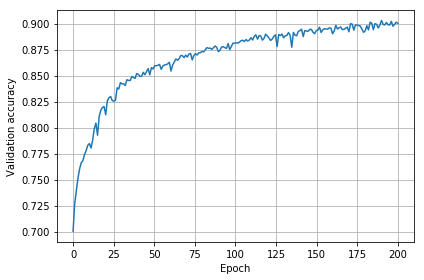

The accuracy of the classifier is 90.03%.


In [297]:
epoch_it = np.linspace(0,nepochs,len(history_cb.val_acc))

plt.plot(epoch_it, history_cb.val_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.tight_layout()
plt.show()
print("The accuracy of the classifier is {0}%.".format(round(history_cb.val_acc[-1]*100,2)))